## USING PYMC3 library
PyMC3 is a library for Bayesian inference, which allows us to run Markov Chain Monte Carlo simulations, and use them to do estimations or sample from distributions.

In this file, we will illustrate two basic examples that should give an idea on how to use the library. 
You can check the online documentation at https://docs.pymc.io/

At the end of the notebook, there is an exercise to start using the library for parameter inference in Markov models.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from theano import tensor as tt
import pymc3 as pm
# from pymc3 import Normal, Categorical, Deterministic, Model, MCMC, stochastic, Beta, MAP
# from pymc.Matplot import plot
from pylab import hist, show
from numpy.random import choice
from matplotlib import pyplot as plt
import seaborn as sns

/home/lpaz/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Sampling from a distribution

Conceptually, given a certain [statistical model](https://en.wikipedia.org/wiki/Statistical_model) (sometimes also referred to as the observed data's generative process) there are three different sampling schemes:
1. Given the assumptions from the data generation process, we can draw samples from it. This is referred to as `sample_prior_predictive` in PyMC3.
2. Lets assume we observed some values that came from the data generation process. We now want to infer the posterior probability distribution of the unobserved random variates given the observed data. To do this, we exploit Bayes Theorem. However, there are models in which it is impossible to compute an analytical form for the posterior, so we must rely on approximate methods. PyMC3 builds heavily on MCMC, where the analytical posterior is not computed, but samples of the unobserved random variates are drawn from it. This procedure is handled by the `sample` function.
3. Given some posterior distribution over unobserved variables, we now want to predict what will be some likely values that we could observe in the future. We do so by sampling from the data generation process, conditioned on the posterior distribution over the unobserved variables. This is called `sample_posterior_predictive`.

In practice, one must first define the statistical model which we assume underlies the data generation process. This is done with the `Model` context manager. After defining the model, one can use any of the three sampling schemes listed above.

---

To illustrate how one defines a model in PyMC3 we use a mixture of two gaussians. We parametrize the model as follows in mathematical notation:

$$
c_{i} \sim Categorical(\alpha, 1-\alpha)
$$
$$
x_{i} \sim N(\mu_{c_{i}}, \tau_{c_{i}})
$$

$c_{i}$ is the category to which the observation belongs to. This category controls the gaussian's mean $\mu_{c_{i}}$ and precision $\tau_{c_{i}}$ (inverse of variance). Lets assume that:
$$
\alpha = 0.8
$$
$$
\mu = [0, 3]
$$
$$
\tau = [1, 1]
$$

One of the development goals of PyMC3 was to make writting down the model as similar as possible to writting down the mathematical relations between the random variables. This involves some symbolic math handling, and PyMC3 relies on [`theano`](http://deeplearning.net/software/theano/) to do so (note that `theano` support has been discontinued and the future PyMC4 version will be written on top of [`tensorflow`](https://www.tensorflow.org/)).

In [3]:
#build a pymc model: this is a mixture of Gaussians.
#This is the model we will sample from

# We start by defining the constant hyper parameters
# (we could do this inside the model context too)
alpha = 0.6
# We wrap sigmas and centers as tensor variables to be able to
# use advanced indexing with symbolic expressions
sigmas = tt.as_tensor_variable([1, 1])
centers = tt.as_tensor_variable([0, 3])

# Now we enter the model context. All random variables within the context
# are assumed to belong to the model, and will be added to the
# bayes graph
with pm.Model() as model:
    # We define the c categorical random variable
    category = pm.Categorical("category", [alpha, 1 - alpha])
    # The category RV is a theano tensor and we can do symbolic math with it
    
    mu = pm.Deterministic('mu', centers[category])
    sigma = pm.Deterministic('sigma', sigmas[category])
    # Just to illustrate the symbolic math capabilities, we pass tau to
    # the Normal, instead of just the sigma
    mixture = pm.Normal('mixture', mu=mu, tau=1/sigma**2)

The `model` object defines the statistical model and holds all the random variates. This simple model has only two types of RVs in it which are:
1. free_RVs: Random variables that are used during the MCMC sampling. In our case these RVs are the `category` and `mixture` random variables.
2. deterministics: Mathematical relations of other variables that we want to track during the MCMC run (we flag that we want to track them with the `pm.Deterministic` function) but they don't contribute explicitly to the posterior probability density. In our case these RVs are `mu` and `sigma`. More details on this later.

In [4]:
# The model instance has refences to all RVs
print(model.free_RVs)
print(model.deterministics)
print(model.basic_RVs)

[category, mixture]
[mu, sigma]
[category, mixture]


In [5]:
# We can access the RVs in the model as attributes or dictionary keys
print(model.mixture)
print(model['mixture'] == model.mixture)

mixture
True


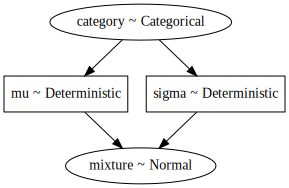

In [6]:
# We can plot the Bayes DAG if we have graphviz installed
pm.model_to_graphviz(model)

Sequential sampling (1 chains in 1 job)
CompoundStep
>BinaryGibbsMetropolis: [category]
>NUTS: [mixture]
100%|██████████| 4500/4500 [00:02<00:00, 1662.40it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/lpaz/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


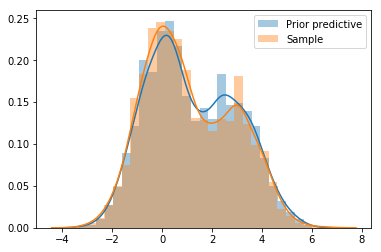

In [7]:
with model:
    prior = pm.sample_prior_predictive(4000)
    # As we don't have any observed data, pm.sample
    # should give the same distribution as the prior
    # This is not safe in general
    trace = pm.sample(4000, cores=1, chains=1)
sns.distplot(prior['mixture'], hist_kws={'alpha': 0.4}, label='Prior predictive')
sns.distplot(trace['mixture'], hist_kws={'alpha': 0.4}, label='Sample')
plt.legend()

The distribution plots don't match nicely because `sample` uses the MCMC procedure whereas `sample_prior_predictive` uses the model's distributions random number generators directly to get what are called forward samples. This procedure is faster and more accurate to generate samples from a given distribution, but does not work well to get samples conditioned on some observed values, which is the entire point of bayesian inference.

So now we turn onto the key question, **how do we sample conditioned on some observations?**

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CategoricalGibbsMetropolis: [category]
>NUTS: [alpha]
Sampling 4 chains: 100%|██████████| 84000/84000 [00:43<00:00, 1931.03draws/s]


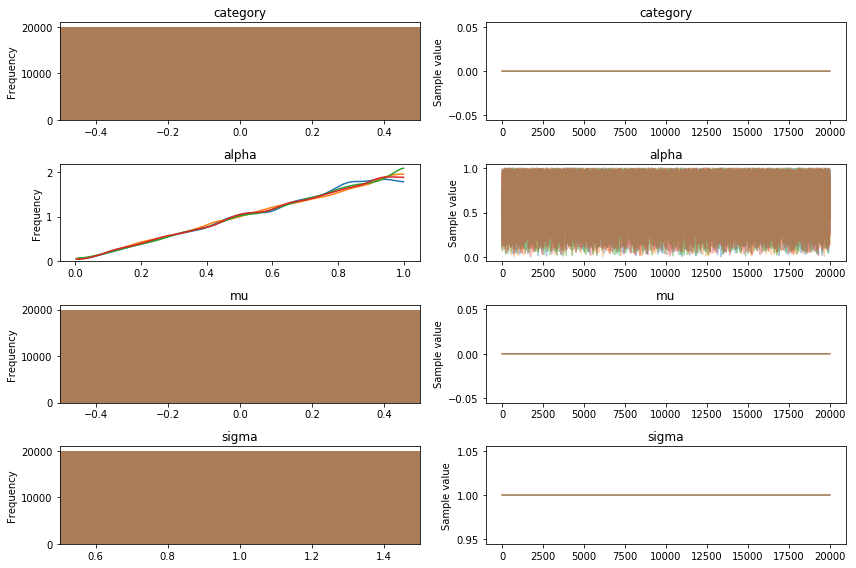

In [9]:
# The observations must be included when the model is defined
# So we have to repeat the model definition. This could be made
# easier with a model factory function.

# We wrap sigmas and centers as tensor variables to be able to
# use advanced indexing with symbolic expressions
sigmas = tt.as_tensor_variable([1, 1])
centers = tt.as_tensor_variable([0, 3])

# Here we set the observed data, we can set it as a numpy.array
# or a pandas.Series. We will rely on the data that we generated with
# the sample_prior_predictive
observed_data = prior['mixture']

# Now we enter the model context. All random variables within the context
# are assumed to belong to the model, and will be added to the
# bayes graph
with pm.Model() as inference_model:
    # To make things more interesting, we define alpha as an RV
    alpha = pm.Beta('alpha', 1, 1)
    # We define the c categorical random variable
    category = pm.Categorical("category", tt.as_tensor_variable([alpha, 1 - alpha]))
    # The category RV is a theano tensor and we can do symbolic math with it
    
    mu = pm.Deterministic('mu', centers[category])
    sigma = pm.Deterministic('sigma', sigmas[category])
    # Just to illustrate the symbolic math capabilities, we pass tau to
    # the Normal, instead of just the sigma
    mixture = pm.Normal('mixture', mu=mu, tau=1/sigma**2,
                        observed=observed_data) # Here we say that we observed this RV

    # In order to perform inference we call pm.sample
    step = pm.CategoricalGibbsMetropolis([category])
    trace = pm.sample(20000, tune=1000, chains=4, cores=4, step=step)
    # We can visualize the markov chains with traceplot
    pm.traceplot(trace)

##### Sampling from a model
The hard part is building the model. The sampling is easy: one defines a MCMC object, samples it, and the plots the trace of the variables of interest (note how each variable has a name to identify it).

In [3]:
#MCMC sampling
M = MCMC(model)
M.sample(iter=10000, burn=1000, thin=10)

 [-----------------100%-----------------] 10000 of 10000 complete in 0.9 sec

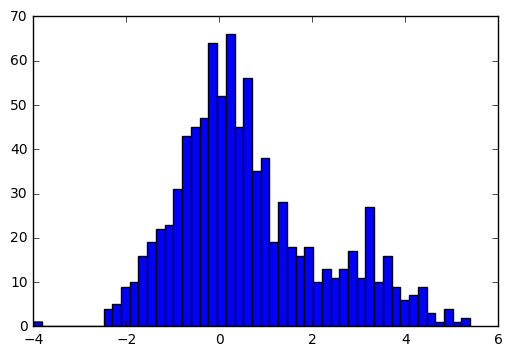

In [4]:
#plot(M)
hist(M.trace('mixture')[:],bins=50)
show()


#### Bayesian inference and user defined stochastic variables
Here we want to do Bayesian inference for a Bernoulli r.v. with parameter p. 
We will define a prior for p, in this case a uniform Beta, then build a user defined model for the Bernoulli variable.

The user defined process uses a `@stochastic` decorator, in this case flagging `observed = True`, which assumes the output of this process is observed. One defines two subfunctions, one computing the log-likelihood and the second to sample from it. Note how the value passed to `my_process` is the vector of the observed values, and we need to compute the log-likelihood of the whole vector in `logp`. 

In [7]:
#sets us an uniform prior
a = 1
b = 1
beta = Beta('parameter',a,b)

#generates observations
N_obs = 1000
p_true = 0.67
observed_values = choice(2, N_obs, p=[1-p_true,p_true])

@stochastic(observed = True, dtype = np.int)
def my_process(value = observed_values, prob = beta):
    """An example of a user defined stochastic process."""

    def logp(value,prob):
        if prob > 1 or prob < 0:
            return -np.inf
        else:
            return np.sum(value*np.log(prob) + (1-value)* np.log(1-prob))

    def random(prob):
        return choice(2, 1, p=[1-prob,prob])
    

##### Posterior approximation or MAP
Once the model is defined, we can sample from the posterior of the parameter, given the observations, or do Maximum a posteriori inference. 

In [9]:
model_inference = Model([my_process,beta])
M = MCMC(model_inference)
M.sample(iter=10000, burn=1000, thin=10)
hist(M.trace('parameter')[:],bins=50)
show()


In [31]:
Mp = MAP(model_inference)
Mp.fit()
p_opt =  Mp.get_node('parameter').get_value()
BIC = Mp.BIC
print("optimal value of parameter is",p_opt,"BIC is",BIC)


optimal value of parameter is 0.6720000004079242 BIC is 1272.41417648


### Exercise
Consider the DTMC of the simple flu model, and assume the probability of infection is a parameter p. 
Fix a value of this p and generate 100 or 1000 samples from the process, storing the state after N steps (say N=1000) so that the dtmc is likely to have reached steady state. 

Build a pyMC model, following the previous example, where the used defined model computes the likelihood by first computing the transient probability after N steps of the DTMC for a given p  (the DTMC can also be passed as a parent to the function `my_process`), and then computes the likelihood of the observations. 

Place a beta prior (e.g. uniform) on the probability p of infection, and do MAP and MCMC inference.



